<img src="https://github.com/big-inpe/cap-423/blob/main/docs-site/images/cap.png?raw=true" align="right" width="120"/>


<div style="text-align: center;">
    <span style="justify-content: center;color:#336699;">
      <h2> Object-based and pixel-based time series classification for land use and cover mapping in Petrolina-PE </h2>
    </span>
</div>
<hr style="border:2px solid #0077b9;">

<div style="text-align: center;font-size: 90%;">
    Pedro Brito and Felipe Carvalho
    <br/><br/>
    Graduate Program in Applied Computing - INPE/CAP 
    <br/>
    Avenida dos Astronautas, 1758, Jardim da Granja, São José dos Campos, SP 12227-010, Brazil
    <br/><br/>
    Contact: <a href="mailto:pedrobritoufrpe@gmail.com">pedrobritoufrpe@gmail.com</a>, <a href="mailto:lipecaso@gmail.com">lipecaso@gmail.com</a>
</div>

<br/>

<div style="text-align: justify;  margin-left: 25%; margin-right: 25%;">
<b>Abstract.</b> This notebook compared two classification approaches, pixel-based and object-based. The comparison was made using validation points.
</div>

## <span style="color:#336699">Import packages</span>

<hr style="border:1px solid #0077b9;">

In [1]:
#
# Import SITS package to produce classifications
#
library(sits)

#
# Import terra package to work with raster data
#
library(terra)

#
# Import sf package to work with vector data
#
library(sf)

#
# Set seed to ensure reproducibility
#
set.seed(123)

SITS - satellite image time series analysis.

Loaded sits v1.5.2.
        See ?sits for help, citation("sits") for use in publication.
        Documentation avaliable in https://e-sensing.github.io/sitsbook/.

Important: Please read "Release Notes for SITS 1.5.2" in
                https://github.com/e-sensing/sits.

terra 1.7.78

Linking to GEOS 3.12.1, GDAL 3.8.5, PROJ 9.4.0; sf_use_s2() is TRUE



## <span style="color:#336699">Define general functions</span>

<hr style="border:1px solid #0077b9;">

In [35]:
optimization_history <- function(tune) {
  acc <- sort(tune$accuracy, decreasing = FALSE)
  acc <- tibble::tibble(
    acc = acc,
    trial = seq_len(length(acc))
  )
  
  p <- ggplot2::ggplot(acc, ggplot2::aes(
    x = .data[["trial"]],
    y = .data[["acc"]]
  ))
  
  p <- p + 
    ggplot2::geom_smooth(
      formula = y ~ x,
      se      = FALSE,
      method  = "loess",
      na.rm   = TRUE
    )
  
  p <- p +
    ggplot2::theme(
      strip.placement = "outside",
      strip.text = ggplot2::element_text(
        colour = "black",
        size   = 11
      ),
      strip.background = ggplot2::element_rect(
        fill  = NA,
        color = NA
      )
    )
  
  p <- p + ggplot2::labs(x = "Trial", y = "Objective Value")
  p
}

#
# Define color palette
#
class_color <- tibble::tibble(name = character(), color = character())
class_color <- class_color |>
  tibble::add_row(name = "Agriculture", color = "#FA8829") |>
  tibble::add_row(name = "Agro-livestock/Bare soil", color = "#fec44f") |>
  tibble::add_row(name = "Arboreal/Shrub vegetation", color = "#115400") |>
  tibble::add_row(name = "Built-up area/Urban", color = "#F816C5") |>
  tibble::add_row(name = "Water bodies", color = "#001AFF") 

#
# Load the color table into `sits`
#
sits_colors_set(colors = class_color, legend = "class_color")

## <span style="color:#336699">Create data cube</span>

<hr style="border:1px solid #0077b9;">

In [14]:
#
# Cube directory
#
cube_dir <- "../data/output/PE/cube/"

#
# Cube bands
#
cube_bands <- c(
  "B02", "B03", "B04", "B08", "B11", "B12", "B8A", "EVI", "NDVI", "CLOUD"
)

#
# Total of workers available
#
multicores <- 24

#
# Create cube directory
#
dir.create(cube_dir, recursive = TRUE, showWarnings = FALSE)

#
# Define working tiles
#
tiles <- c("035015", "036015", "036016")

#
# Define region of interest
#
roi <- sf::st_read("../data/output/PE/shape_petrolina/limite_petrolina.shp", quiet = TRUE)

#
# Define dates
#
start_date <- "2021-10-16"
end_date <- "2022-09-30"

#
# Create Sentinel-2 data cube
#
cube <- sits_cube(
    source     = "BDC",
    collection = "SENTINEL-2-16D",
    tiles      = tiles,
    start_date = start_date,
    end_date   = end_date,
    bands      = cube_bands
)

  |======================================================================| 100%


In [3]:
#
# View Sentinel-2 cube
#
print(cube)

# A tibble: 3 × 12
  source collection     satellite sensor tile    xmin   xmax   ymin   ymax crs  
  <chr>  <chr>          <chr>     <chr>  <chr>  <dbl>  <dbl>  <dbl>  <dbl> <chr>
1 BDC    SENTINEL-2-16D SENTINEL… MSI    0350… 6.32e6 6.43e6 1.03e7 1.04e7 "PRO…
2 BDC    SENTINEL-2-16D SENTINEL… MSI    0360… 6.43e6 6.53e6 1.03e7 1.04e7 "PRO…
3 BDC    SENTINEL-2-16D SENTINEL… MSI    0360… 6.43e6 6.53e6 1.02e7 1.03e7 "PRO…
# ℹ 2 more variables: labels <list>, file_info <list>


## <span style="color:#336699">Read Samples</span>

<hr style="border:1px solid #0077b9;">

In [4]:
#
# Define samples path
#
samples_file <- "../data/output/PE/time_series/clean_samples_2019_2020_band.rds"

#
# Load samples
#
samples <- readRDS(samples_file)

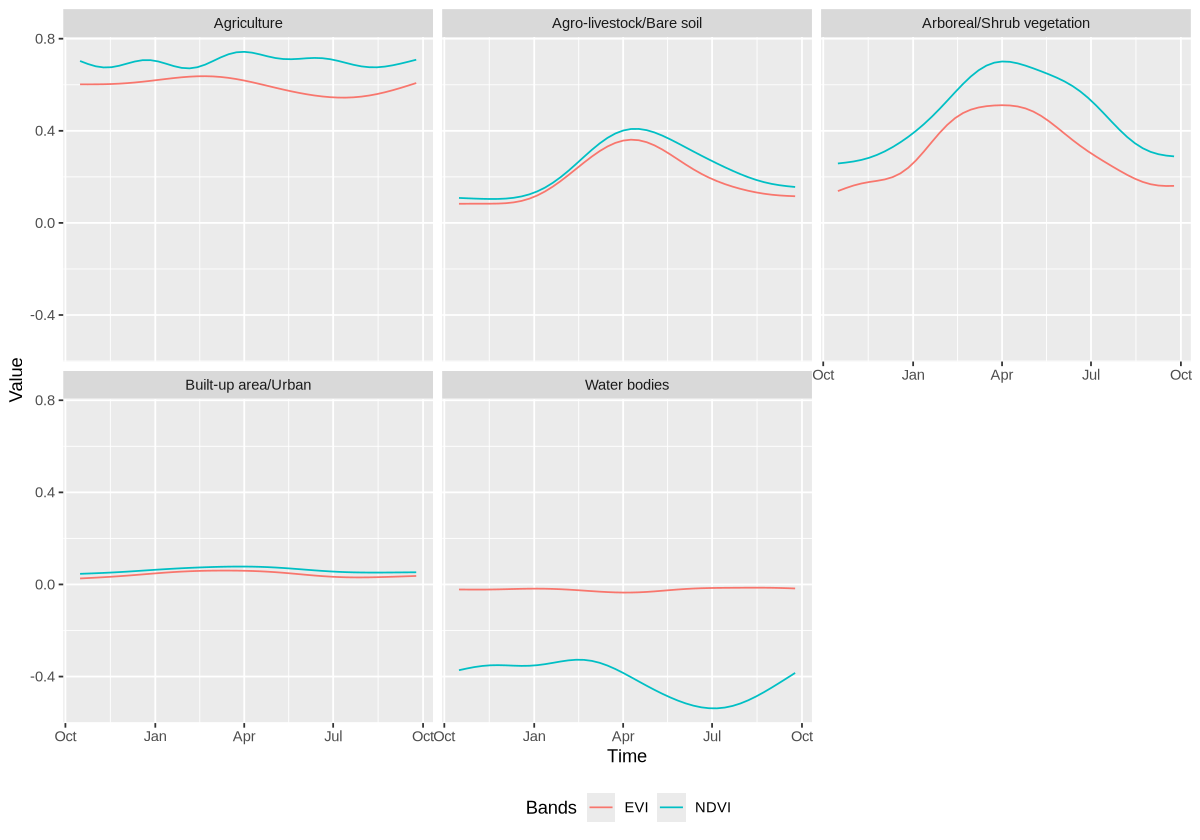

In [12]:
#
# View samples patterns
#
options(repr.plot.width = 10, repr.plot.height = 7)
plot(sits_patterns(sits_select(samples, bands = c("EVI", "NDVI"))))

## <span style="color:#336699">Tune TempCNN model</span>

<hr style="border:1px solid #0077b9;">

In [ ]:
#
# Tune tempCNN model hiperparameters
#
tuned_tempcnn <- sits_tuning(
  samples   = samples,
  ml_method = sits_tempcnn(),
  params        = sits_tuning_hparams(
    optimizer   = torch::optim_adamw,
    cnn_kernels = choice(c(3, 3, 3), c(5, 5, 5), c(7, 7, 7)),
    cnn_layers  = choice(c(2^5, 2^5, 2^5), c(2^6, 2^6, 2^6), c(2^7, 2^7, 2^7)),
    opt_hparams = list(
            lr = loguniform(10^-2, 10^-4)
        )
  ),
  trials     = 50,
  multicores = 20,
  progress   = TRUE
)

In [ ]:
# 
# Define tuned path
#
tuning_dir <- "../data/output/PE/tune/tempcnn/"
dir.create(tuning_dir, recursive = TRUE, showWarnings = FALSE)

# 
# Save tuned results
#
saveRDS(tuned_tempcnn, paste0(tuning_dir, "tempcnn_pe.rds"))

In [5]:
# 
# Load tuned results
#
tuned_tempcnn <- readRDS("../data/output/PE/tune/tempcnn/tempcnn_pe.rds")

# 
# View best tuned params
#
print(tuned_tempcnn)

# A tibble: 50 × 19
   accuracy kappa acc        samples_validation cnn_layers       cnn_kernels
      <dbl> <dbl> <list>     <list>             <chr>            <chr>      
 1    0.989 0.986 <cnfsnMtr> <NULL>             c(2^6, 2^6, 2^6) c(7, 7, 7) 
 2    0.989 0.986 <cnfsnMtr> <NULL>             c(2^7, 2^7, 2^7) c(3, 3, 3) 
 3    0.989 0.986 <cnfsnMtr> <NULL>             c(2^5, 2^5, 2^5) c(7, 7, 7) 
 4    0.984 0.979 <cnfsnMtr> <NULL>             c(2^7, 2^7, 2^7) c(3, 3, 3) 
 5    0.984 0.979 <cnfsnMtr> <NULL>             c(2^7, 2^7, 2^7) c(5, 5, 5) 
 6    0.984 0.979 <cnfsnMtr> <NULL>             c(2^6, 2^6, 2^6) c(7, 7, 7) 
 7    0.978 0.972 <cnfsnMtr> <NULL>             c(2^7, 2^7, 2^7) c(3, 3, 3) 
 8    0.978 0.972 <cnfsnMtr> <NULL>             c(2^5, 2^5, 2^5) c(7, 7, 7) 
 9    0.978 0.972 <cnfsnMtr> <NULL>             c(2^5, 2^5, 2^5) c(5, 5, 5) 
10    0.978 0.972 <cnfsnMtr> <NULL>             c(2^7, 2^7, 2^7) c(5, 5, 5) 
# ℹ 40 more rows
# ℹ 13 more variables: cnn_dropout_rate

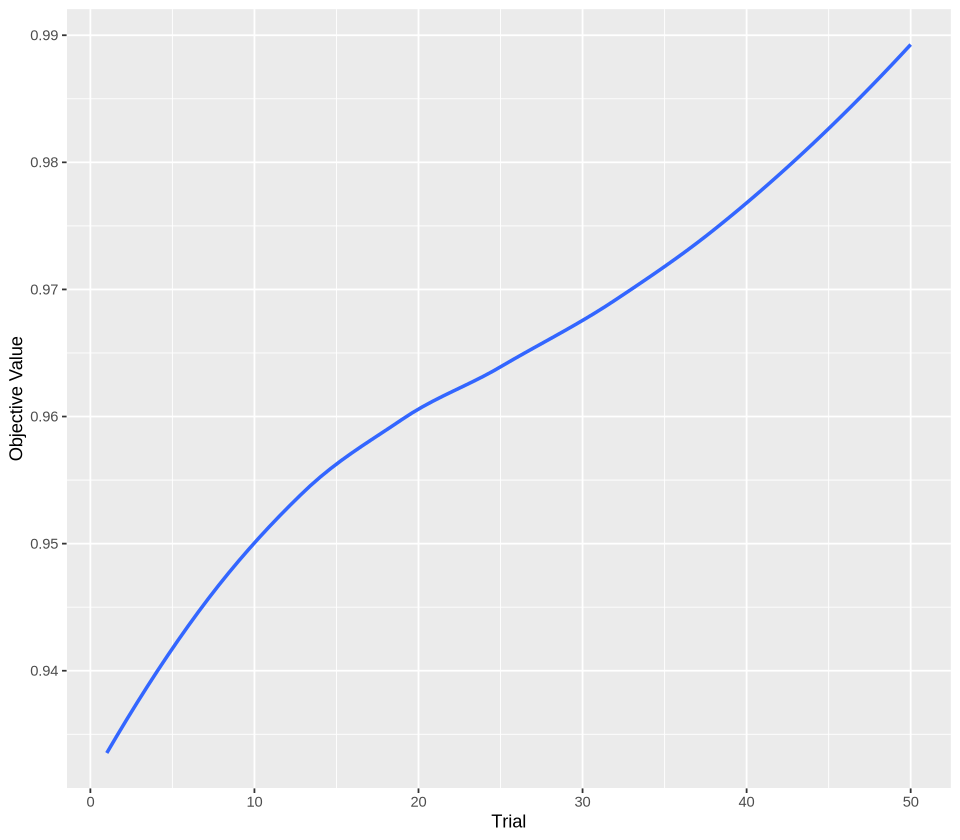

In [29]:
#
# Optimization history plot
#
options(repr.plot.width = 8, repr.plot.height = 7)
optimization_history(tuned_tempcnn)

## <span style="color:#336699">Train TempCNN model</span>

<hr style="border:1px solid #0077b9;">

In [ ]:
#
# Train tempCNN model with best hiperparameters found
#
tcnn_model <- sits_train(
    samples, sits_tempcnn(
          cnn_layers = c(2^6, 2^6, 2^6),
          cnn_kernels = c(7, 7, 7),
          cnn_dropout_rates = c(0.2, 0.2, 0.2),
          dense_layer_nodes = 256,
          dense_layer_dropout_rate = 0.5,
          epochs = 150,
          batch_size = 64,
          optimizer = torch::optim_adamw,
          opt_hparams = list(lr = 0.0003105814),
          patience = 20,
          min_delta = 0.01,
          verbose = FALSE
    )
)

In [ ]:
#
# Define output directory
#
base_model_dir <- "../data/output/PE/model/"
tcnn_dir <- paste0(base_model_dir, "tcnn_model.rds")  

#
# Create directory
#
dir.create(base_model_dir, recursive = TRUE, showWarnings = FALSE)

#
# Save best model
#
saveRDS(tcnn_model, tcnn_dir)

In [6]:
#
# Read trained model
#
tcnn_model <- readRDS("../data/output/PE/model/tcnn_model.rds")

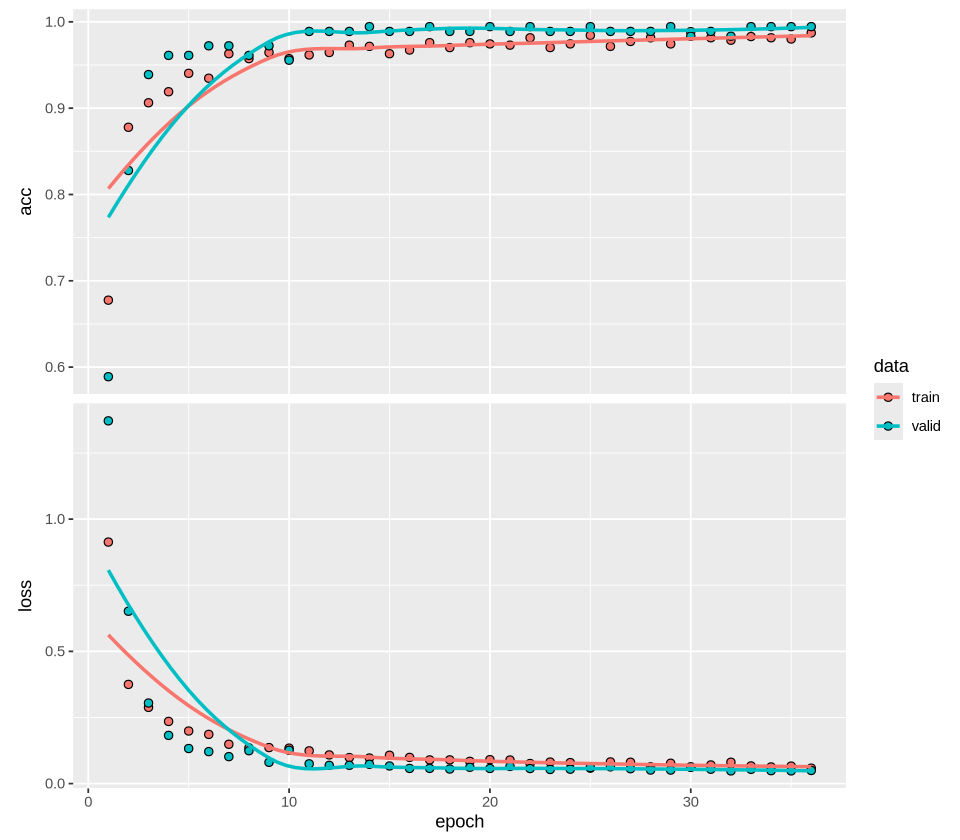

In [32]:
#
# Accuracy and validation curves
#
options(repr.plot.width = 8, repr.plot.height = 7)
plot(tcnn_model)

## <span style="color:#336699">Tune LightTAE model</span>

<hr style="border:1px solid #0077b9;">

In [ ]:
#
# Tune lightttae model 
#
tuned_lighttae <- sits_tuning(
  samples   = samples,
  ml_method = sits_lighttae(),
  params        = sits_tuning_hparams(
    optimizer   = torch::optim_adamw,
    opt_hparams = list(
      lr           = loguniform(10^-2, 10^-4),
      weight_decay = loguniform(10^-2, 10^-8)
    )
  ),
  trials     = 50,
  multicores = 10,
  progress   = TRUE
)

In [ ]:
# 
# Define output directory
#
tuning_dir <- "../data/output/PE/tune/lighttae/"

# 
# Create directory
#
dir.create(tuning_dir, recursive = TRUE, showWarnings = FALSE)

# 
# Save model
#
saveRDS(tuned_lighttae, paste0(tuning_dir, "lighttae_pe.rds"))

In [7]:
#
# Read tuned parameters
#
tuned_lighttae <- readRDS("../data/output/PE/tune/lighttae/lighttae_pe.rds")

In [34]:
# 
# View best tuned params
#
print(tuned_lighttae)

# A tibble: 50 × 14
   accuracy kappa acc        samples_validation epochs batch_size
      <dbl> <dbl> <list>     <list>              <dbl>      <dbl>
 1    0.989 0.986 <cnfsnMtr> <NULL>                150        128
 2    0.984 0.979 <cnfsnMtr> <NULL>                150        128
 3    0.984 0.979 <cnfsnMtr> <NULL>                150        128
 4    0.984 0.979 <cnfsnMtr> <NULL>                150        128
 5    0.984 0.979 <cnfsnMtr> <NULL>                150        128
 6    0.978 0.972 <cnfsnMtr> <NULL>                150        128
 7    0.978 0.972 <cnfsnMtr> <NULL>                150        128
 8    0.978 0.972 <cnfsnMtr> <NULL>                150        128
 9    0.978 0.972 <cnfsnMtr> <NULL>                150        128
10    0.978 0.972 <cnfsnMtr> <NULL>                150        128
# ℹ 40 more rows
# ℹ 8 more variables: validation_split <dbl>, optimizer <list>,
#   opt_hparams <list>, lr_decay_epochs <int>, lr_decay_rate <dbl>,
#   patience <int>, min_delta <dbl>, ve

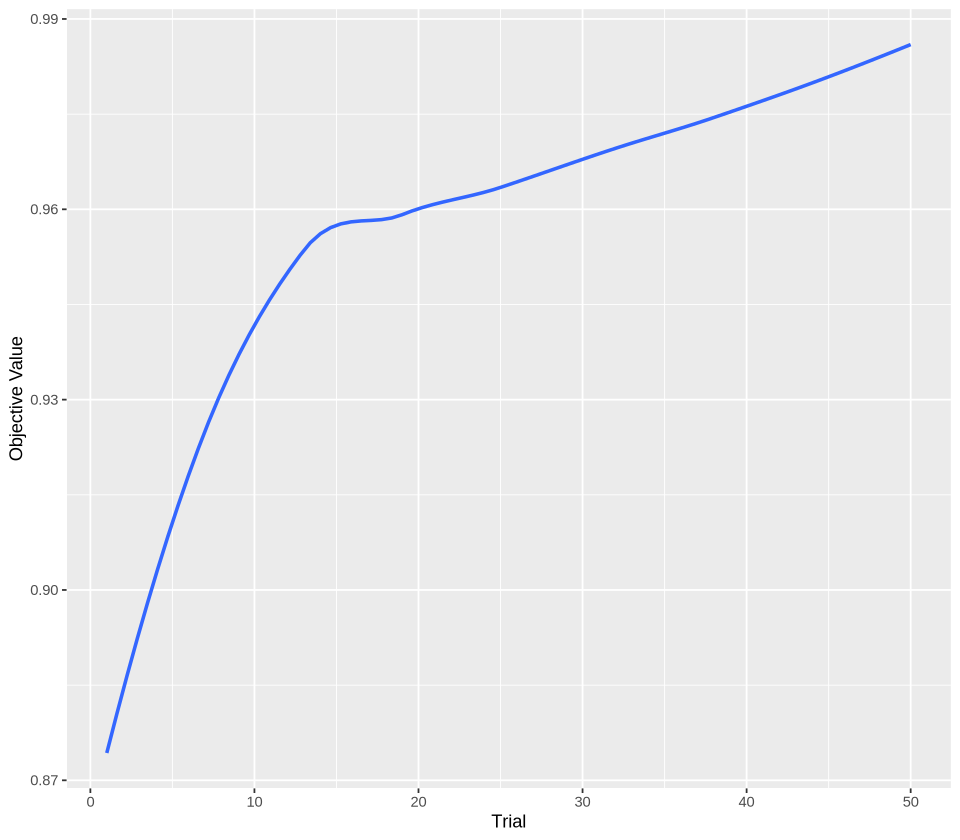

In [35]:
#
# Optimization history plot
#
options(repr.plot.width = 8, repr.plot.height = 7)
optimization_history(tuned_lighttae)

## <span style="color:#336699">Train LightTAE model</span>

<hr style="border:1px solid #0077b9;">

In [ ]:
#
# Train LightTAE model with best hiperparameters found
#
lighttae_model <- sits_train(
    samples, sits_lighttae(
      epochs = 150,
      batch_size = 128,
      optimizer = torch::optim_adamw,
      opt_hparams = list(lr = 0.000273, weight_decay = 0.00161),
      lr_decay_epochs = 50L,
      patience = 20L,
      min_delta = 0.01,
      verbose = FALSE
    )
)

In [ ]:
#
# Define output directory
#
base_model_dir <- "../data/output/PE/model/"
ltae_dir <- paste0(base_model_dir, "ltae_model.rds")  

#
# Save best model
#
saveRDS(lighttae_model, ltae_dir)

In [8]:
#
# Read trained model
#
lighttae_model <- readRDS("../data/output/PE/model/ltae_model.rds")

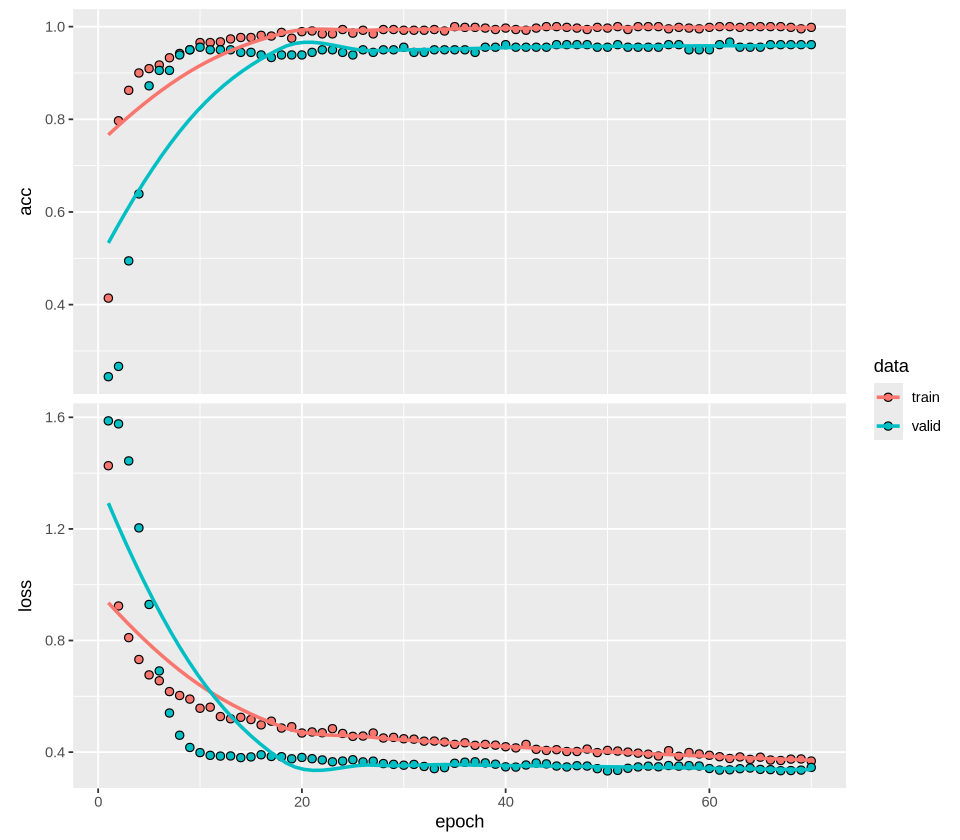

In [38]:
#
# Accuracy and validation curves
#
options(repr.plot.width = 8, repr.plot.height = 7)
plot(lighttae_model)

## <span style="color:#336699">Pixel-based classification - TCNN</span>

<hr style="border:1px solid #0077b9;">

In [49]:
#
# Define output directory
#
output_dir <- "../data/output/PE/classifications/tccn"

#
# Define version name
#
results_version <- "tcnn-8cls"

#
# Create output directory
#
dir.create(output_dir, recursive = TRUE, showWarnings = FALSE)

#
# Classify data cube
#
probs_cube <- sits_classify(
    data       = cube,
    ml_model   = tcnn_model,
    memsize    = 54,
    gpu_memory = 10,
    multicores = 24,
    output_dir = output_dir,
    version    = results_version,
    progress   = FALSE
)

#
# Apply spatial smooth
#
probs_bayes <- sits_smooth(
    cube           = probs_cube,
    window_size    = 9,
    neigh_fraction = 0.5,
    memsize        = 60,
    multicores     = 24,
    output_dir     = output_dir,
    version        = results_version
)

#
# Generate map
#
class_cube <- sits_label_classification(
    cube       = probs_bayes,
    memsize    = 60,
    multicores = 24,
    output_dir = output_dir,
    version    = results_version
)

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version



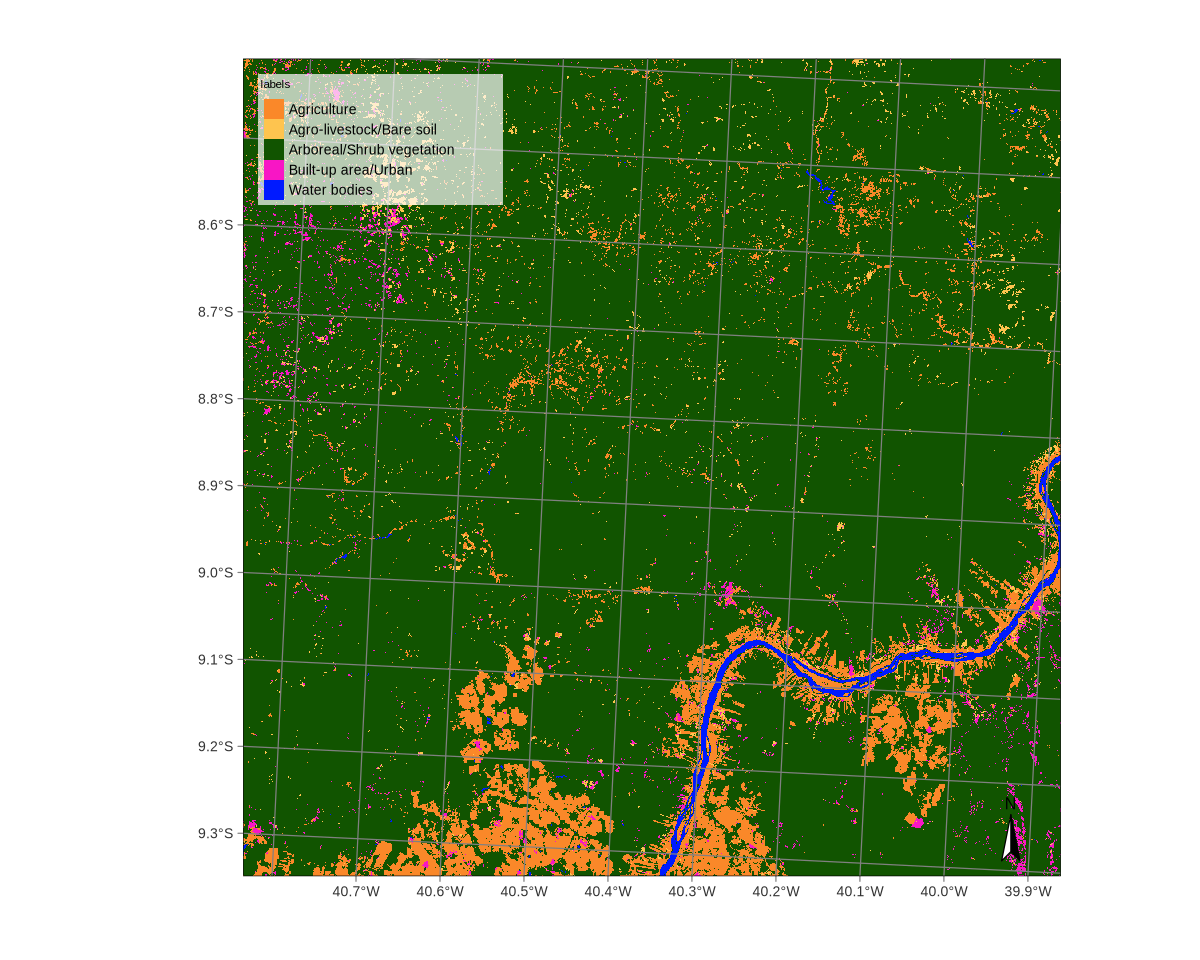

In [50]:
#
# View the second classified tile
#
plot(class_cube[2,])

## <span style="color:#336699">Pixel-based classification - LightTAE</span>

<hr style="border:1px solid #0077b9;">

In [47]:
#
# Define output directory
#
output_dir <- "../data/output/PE/classifications/lighttae"

#
# Define version name
#
results_version <- "lighttaeb-8cls"

#
# Create output directory
#
dir.create(output_dir, recursive = TRUE, showWarnings = FALSE)

#
# Classify data cube
#
probs_cube <- sits_classify(
    data       = cube,
    ml_model   = lighttae_model,
    memsize    = 54,
    gpu_memory = 10,
    multicores = 24,
    output_dir = output_dir,
    version    = results_version,
    progress   = FALSE
)

#
# Apply spatial smooth
#
probs_bayes <- sits_smooth(
    cube           = probs_cube,
    window_size    = 9,
    neigh_fraction = 0.5,
    memsize        = 60,
    multicores     = 24,
    output_dir     = output_dir,
    version        = results_version
)

#
# Generate map
#
class_cube <- sits_label_classification(
    cube       = probs_bayes,
    memsize    = 60,
    multicores = 24,
    output_dir = output_dir,
    version    = results_version
)

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version



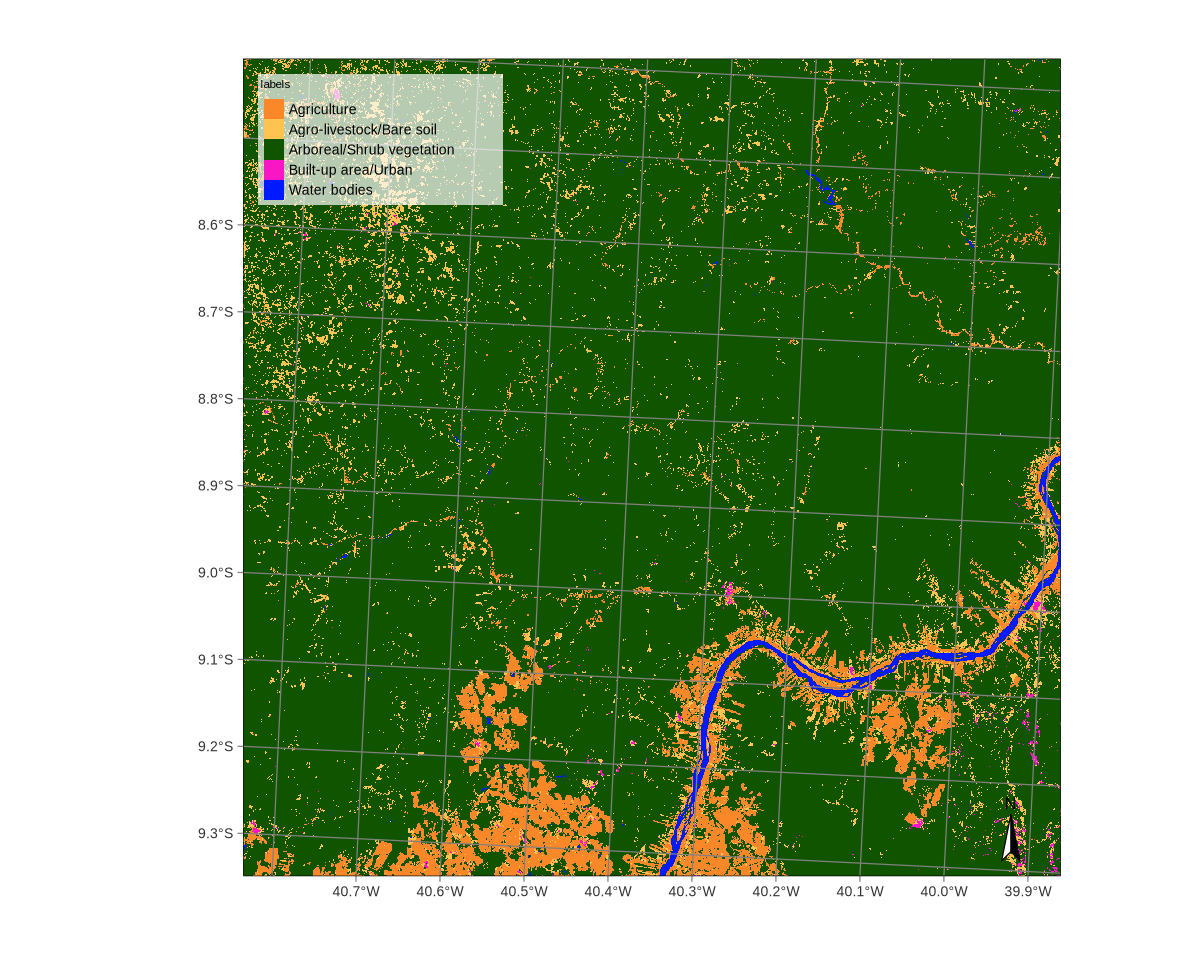

In [48]:
#
# View the second classified tile
#
plot(class_cube[2,])

## <span style="color:#336699">Apply Spatial-temporal segmentation</span>

<hr style="border:1px solid #0077b9;">

In [10]:
#
# Define output directory
#
segment_dir <- "../data/output/PE/segment/"

#
# Apply spatio-temporal segmentation in Sentinel-2 cube 
#
segments <- sits_segment(
  cube = cube,
  seg_fn = sits_slic(
    step = 20,
    compactness = 1,
    dist_fun = "euclidean",
    iter = 20,
    minarea = 20
  ),
  output_dir = segment_dir,
  memsize    = 30,
  multicores = 12
)

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version



## <span style="color:#336699">Object-based classification - TCNN</span>

<hr style="border:1px solid #0077b9;">

In [15]:
#
# Define output directory
#
output_dir <- "../data/output/PE/segment/tcnn"

#
# Define version name
#
results_version <- "tcnn-8cls-segments"

#
# Create directory
#
dir.create(output_dir, recursive = TRUE, showWarnings = FALSE)

#
# Classify object-based data cube
#
probs_cube <- sits_classify(
    data       = segments,
    ml_model   = tcnn_model,
    n_sam_pol  = 40,
    memsize    = 8,
    gpu_memory = 10,
    multicores = 24,
    output_dir = output_dir,
    version    = results_version,
    roi        = roi,
    progress   = TRUE
)

#
# Generate map
#
class_cube <- sits_label_classification(
    cube       = probs_cube,
    memsize    = 30,
    multicores = 12,
    output_dir = output_dir,
    version    = results_version
)

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version



## <span style="color:#336699">Object-based classification - LightTAE</span>

<hr style="border:1px solid #0077b9;">

In [18]:
#
# Define output directory
#
output_dir <- "../data/output/PE/segment/ltae"

#
# Define version name
#
results_version <- "ltae-8cls-segments"

#
# Create directory
#
dir.create(output_dir, recursive = TRUE, showWarnings = FALSE)

#
# Classify object-based data cube
#
probs_cube <- sits_classify(
    data       = segments,
    ml_model   = lighttae_model,
    n_sam_pol  = 40,
    memsize    = 8,
    gpu_memory = 10,
    multicores = 24,
    roi        = roi,
    output_dir = output_dir,
    version    = results_version,
    progress   = FALSE,
    verbose    = FALSE
)

#
# Generate map
#
class_cube <- sits_label_classification(
    cube       = probs_cube,
    memsize    = 30,
    multicores = 12,
    output_dir = output_dir,
    version    = results_version
)

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version



## <span style="color:#336699">Read validation samples</span>

<hr style="border:1px solid #0077b9;">

In [19]:
#
# Read validation samples
#
samples_val <- read.csv("../data/output/PE/samples/validation_samples/validation_samples_petrolina_2019_2020.csv")

#
# View the first 10 samples
#
head(samples_val, n = 10)

id longitude latitude  start_date end_date   label      
1   1 -40.42631 -9.257637 2019-10-01 2020-09-30 Agriculture
2   2 -40.49639 -9.300568 2019-10-01 2020-09-30 Agriculture
3   3 -40.51396 -9.155946 2019-10-01 2020-09-30 Agriculture
4   4 -40.51949 -9.255985 2019-10-01 2020-09-30 Agriculture
5   5 -40.35861 -9.354720 2019-10-01 2020-09-30 Agriculture
6   6 -40.56763 -9.383339 2019-10-01 2020-09-30 Agriculture
7   7 -40.41106 -9.295216 2019-10-01 2020-09-30 Agriculture
8   8 -40.53875 -9.346849 2019-10-01 2020-09-30 Agriculture
9   9 -40.67038 -9.303548 2019-10-01 2020-09-30 Agriculture
10 10 -40.59240 -9.289816 2019-10-01 2020-09-30 Agriculture

## <span style="color:#336699"> Validation pixel-based - TCNN</span>

<hr style="border:1px solid #0077b9;">

In [21]:
#
# Define model labels
#
labels <- sits_labels(tcnn_model)
names(labels) <- seq_len(length(labels))

In [44]:
#
# Define classification cube
#
class_tcnn <- sits_cube(
    source     = "BDC",
    collection = "SENTINEL-2-16D",
    data_dir   = "../data/output/PE/classifications/tccn/",
    bands      = "class",
    labels     = labels,
    version    = "tcnn-8cls"
)

#
# Create classifications mosaic
#
mosaic_tcnn <- sits_mosaic(
    cube = class_tcnn,
    roi = roi,
    crs = "+proj=aea +lat_0=-12 +lon_0=-54 +lat_1=-2 +lat_2=-22 +x_0=5000000 +y_0=10000000 +ellps=GRS80 +units=m +no_defs",
    multicores = 2,
    output_dir = "../data/output/PE/classifications/tccn/",
    version    = "tcnn-8cls"
)

#
# Compute map accuracy
#
acc_tcnn <- sits_accuracy(
    data = mosaic_tcnn,
    validation = samples_val,
    method = "pixel"
)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


In [45]:
#
# Print CNN pixel-based classification
#
acc_tcnn

Confusion Matrix and Statistics

                           Reference
Prediction                  Agriculture Built-up area/Urban Water bodies
  Agriculture                        50                   0            0
  Built-up area/Urban                 0                  49            0
  Water bodies                        0                   0           50
  Agro-livestock/Bare soil            0                   1            0
  Arboreal/Shrub vegetation           0                   0            0
                           Reference
Prediction                  Agro-livestock/Bare soil Arboreal/Shrub vegetation
  Agriculture                                      0                         0
  Built-up area/Urban                             14                         0
  Water bodies                                     0                         0
  Agro-livestock/Bare soil                        13                         0
  Arboreal/Shrub vegetation                       23        

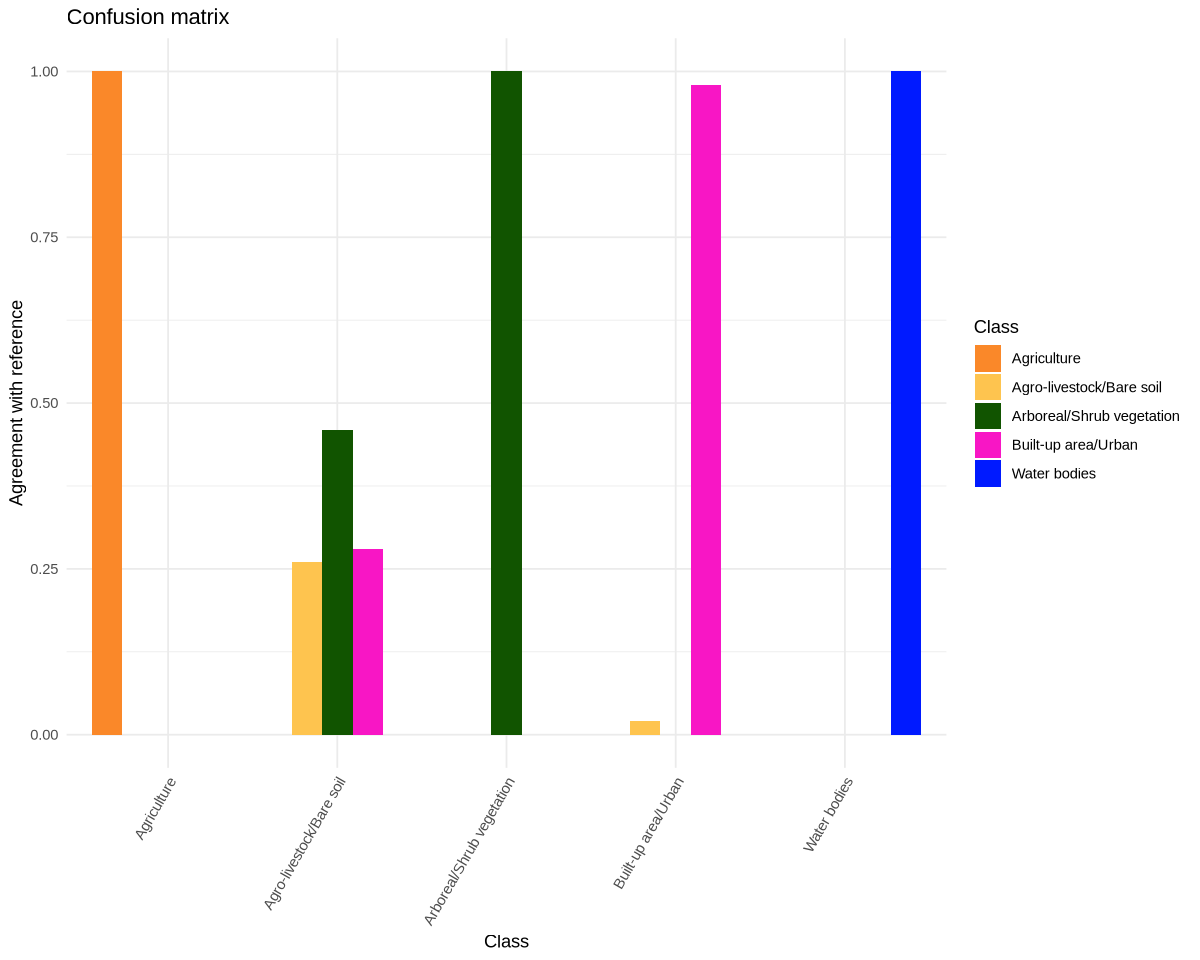

In [46]:
#
# Confusion between classes
#
options(repr.plot.width = 10, repr.plot.height = 8)
plot(acc_tcnn)

## <span style="color:#336699"> Validation pixel-based - LightTAE</span>

<hr style="border:1px solid #0077b9;">

In [41]:
#
# Define classification cube
#
class_ltae <- sits_cube(
    source     = "BDC",
    collection = "SENTINEL-2-16D",
    data_dir   = "../data/output/PE/classifications/lighttae/",
    bands      = "class",
    labels     = labels,
    version    = "lighttaeb-8cls"
)

#
# Create classifications mosaic
#
mosaic_ltae <- sits_mosaic(
    cube = class_ltae,
    roi = roi,
    crs = "+proj=aea +lat_0=-12 +lon_0=-54 +lat_1=-2 +lat_2=-22 +x_0=5000000 +y_0=10000000 +ellps=GRS80 +units=m +no_defs",
    multicores = 2,
    output_dir = "../data/output/PE/classifications/lighttae/",
    version    = "lighttaeb-8cls"
)

#
# Compute map accuracy
#
acc_ltae <- sits_accuracy(
    data = mosaic_ltae,
    validation = samples_val,
    method = "pixel"
)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


In [42]:
#
# Print CNN pixel-based classification
#
acc_ltae

Confusion Matrix and Statistics

                           Reference
Prediction                  Agriculture Built-up area/Urban Water bodies
  Agriculture                        50                   0            0
  Built-up area/Urban                 0                  44            0
  Water bodies                        0                   0           50
  Agro-livestock/Bare soil            0                   6            0
  Arboreal/Shrub vegetation           0                   0            0
                           Reference
Prediction                  Agro-livestock/Bare soil Arboreal/Shrub vegetation
  Agriculture                                      0                         0
  Built-up area/Urban                              2                         0
  Water bodies                                     0                         0
  Agro-livestock/Bare soil                        38                         0
  Arboreal/Shrub vegetation                       10        

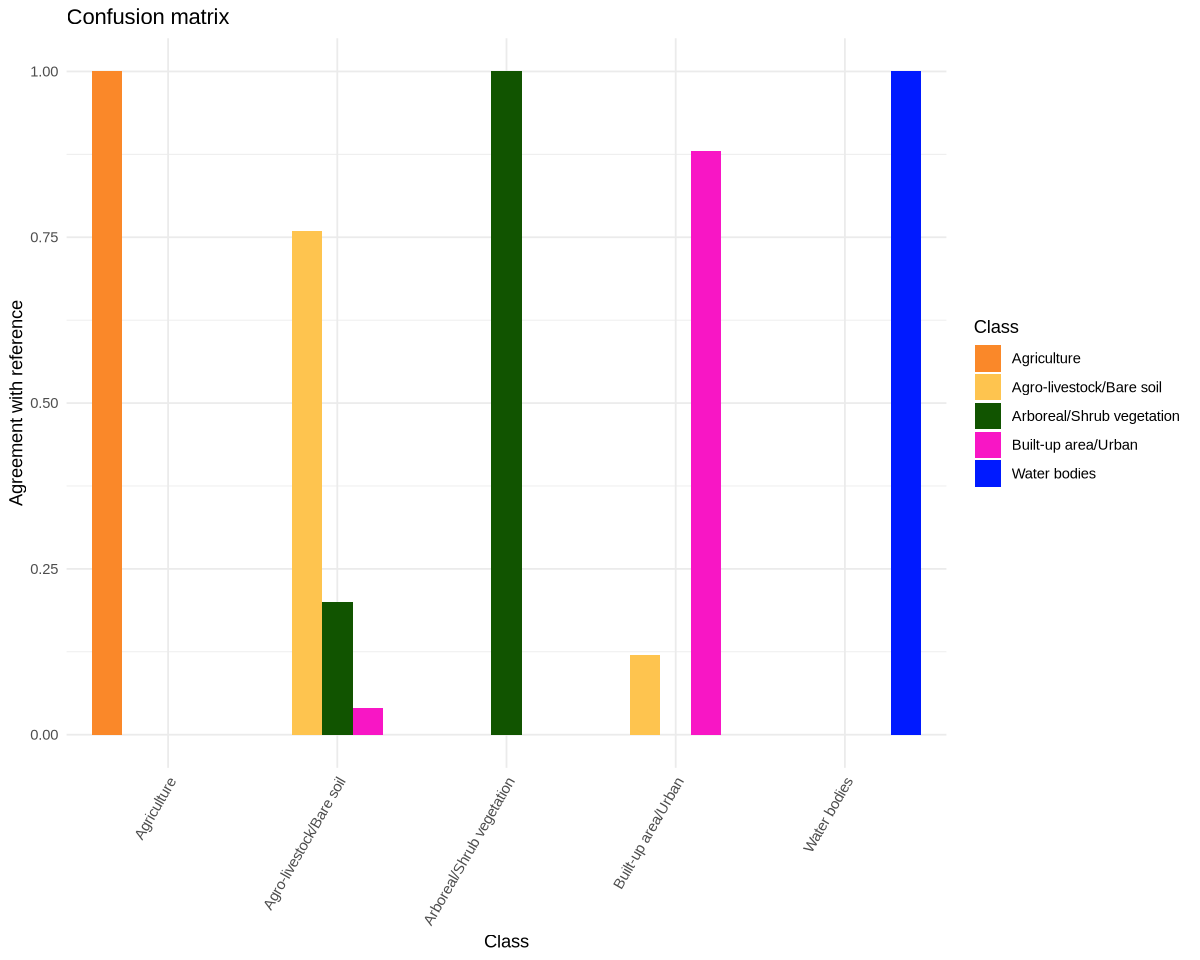

In [43]:
#
# Confusion between classes
#
options(repr.plot.width = 10, repr.plot.height = 8)
plot(acc_ltae)

## <span style="color:#336699"> Validation object-based - TCNN</span>

<hr style="border:1px solid #0077b9;">

In [27]:
#
# List segments files
#
tiles_to_mosaic <- list.files(
    "../data/output/PE/segment/tcnn/", 
    full.names = TRUE,
    pattern = "class.*\\.gpkg"
)

#
# Read each segment
#
tiles_lst <- lapply(tiles_to_mosaic, sf::st_read, quiet = TRUE)

#
# Combine all segments
#
tiles_vec <- dplyr::bind_rows(tiles_lst)

#
# Define a rast template
#
rast_template <- terra::rast("../data/output/PE/classifications/tccn/SENTINEL-2_MSI_MOSAIC_2021-10-16_2022-09-30_class_tcnn-8cls.tif")

#
# Creating a new column with interger values
#
tiles_vec <- tiles_vec |>
  dplyr::mutate(
    label_val = dplyr::case_when(
      class == "Agriculture" ~ 1,
      class == "Agro-livestock/Bare soil" ~ 2,
      class == "Arboreal/Shrub vegetation" ~ 3,
      class == "Built-up area/Urban" ~ 4,
      class == "Water bodies" ~ 5
    )
)

#
# Rasterize classified polygons
#
rasterize_cnn <- terra::rasterize(
    x = terra::vect(tiles_vec), 
    y = terra::rast(rast_template), 
    field = "label_val"
)

#
# Write rasterized polygons
#
terra::writeRaster(
    x = rasterize_cnn, 
    filename = "../data/output/PE/segment/tcnn/SENTINEL-2_MSI_MOSAIC_2021-10-16_2022-09-30_class_tcnn-8cls-segments-rasterize.tif",
    gdal = c("COMPRESS=LZW", "PREDICTOR=2", "BIGTIFF=YES",
             "TILED=YES", "BLOCKXSIZE=512", "BLOCKYSIZE=512"),
    datatype = "INT1U"
)

In [28]:
#
# Define classification cube
#
class_tcnn <- sits_cube(
    source     = "BDC",
    collection = "SENTINEL-2-16D",
    data_dir   = "../data/output/PE/segment/tcnn/",
    bands      = "class",
    labels     = labels,
    version    = "tcnn-8cls-segments-rasterize"
)

#
# Compute map accuracy
#
acc_tcnn <- sits_accuracy(
    data = class_tcnn,
    validation = samples_val,
    method = "pixel"
)

  |======================================================================| 100%


In [29]:
#
# Print CNN object-based classification
#
acc_tcnn

Confusion Matrix and Statistics

                           Reference
Prediction                  Agriculture Built-up area/Urban Water bodies
  Agriculture                        49                   0            0
  Built-up area/Urban                 0                  46            0
  Water bodies                        0                   0           50
  Agro-livestock/Bare soil            1                   2            0
  Arboreal/Shrub vegetation           0                   2            0
                           Reference
Prediction                  Agro-livestock/Bare soil Arboreal/Shrub vegetation
  Agriculture                                      0                         0
  Built-up area/Urban                              9                         0
  Water bodies                                     0                         0
  Agro-livestock/Bare soil                        23                         0
  Arboreal/Shrub vegetation                       18        

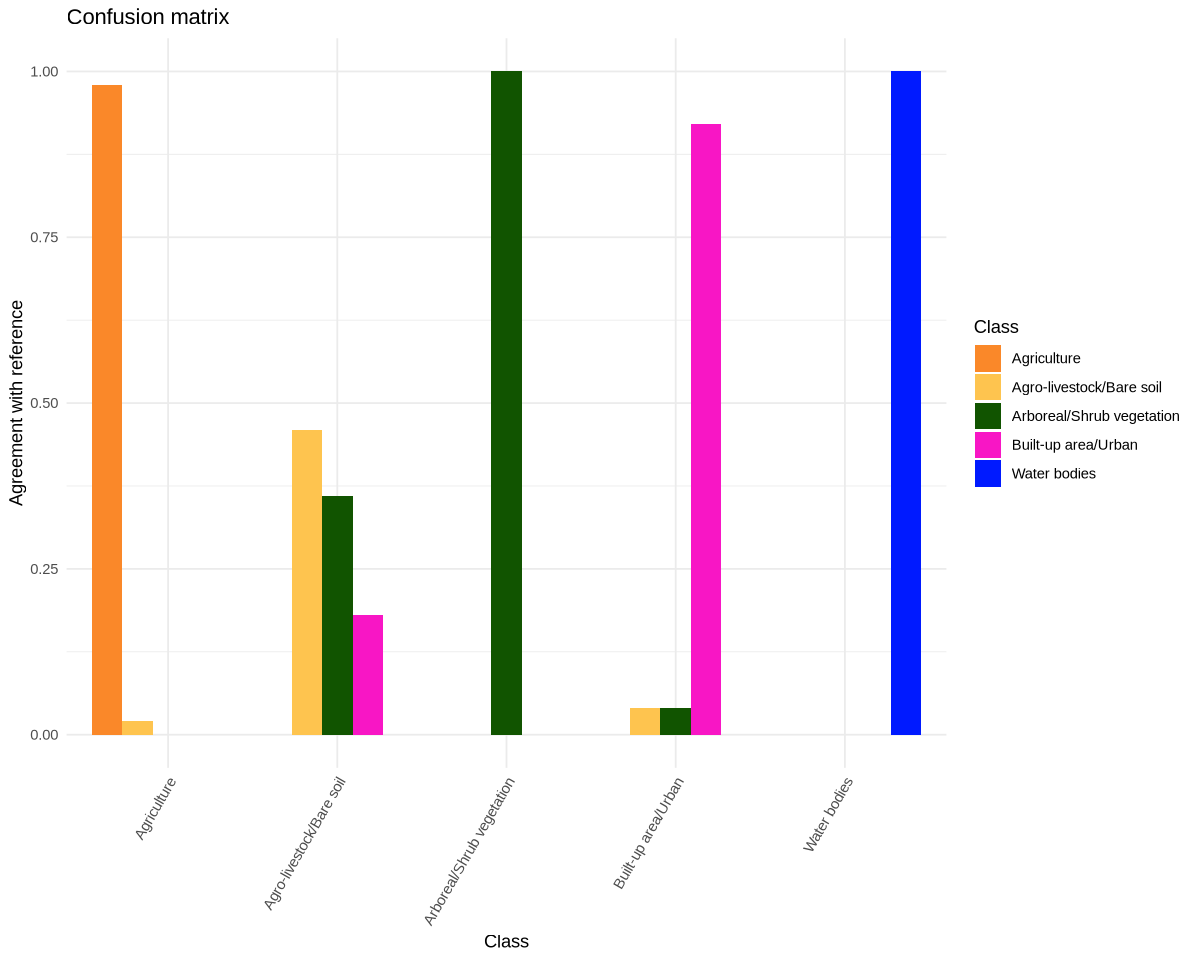

In [39]:
#
# Confusion between classes
#
options(repr.plot.width = 10, repr.plot.height = 8)
plot(acc_tcnn)

## <span style="color:#336699"> Validation object-based - LTAE</span>

<hr style="border:1px solid #0077b9;">

In [31]:
#
# List segments files
#
tiles_to_mosaic <- list.files(
    "../data/output/PE/segment/ltae/", 
    full.names = TRUE,
    pattern = "class.*\\.gpkg"
)

#
# Read each segment
#
tiles_lst <- lapply(tiles_to_mosaic, sf::st_read, quiet = TRUE)

#
# Combine all segments
#
tiles_vec <- dplyr::bind_rows(tiles_lst)

#
# Define a rast template
#
rast_template <- terra::rast("../data/output/PE/classifications/lighttae/SENTINEL-2_MSI_MOSAIC_2021-10-16_2022-09-30_class_lighttaeb-8cls.tif")

#
# Creating a new column with interger values
#
tiles_vec <- tiles_vec |>
  dplyr::mutate(
    label_val = dplyr::case_when(
      class == "Agriculture" ~ 1,
      class == "Agro-livestock/Bare soil" ~ 2,
      class == "Arboreal/Shrub vegetation" ~ 3,
      class == "Built-up area/Urban" ~ 4,
      class == "Water bodies" ~ 5
    )
)

#
# Rasterize classified polygons
#
rasterize_ltae <- terra::rasterize(
    x = terra::vect(tiles_vec), 
    y = terra::rast(rast_template), 
    field = "label_val"
)

#
# Write rasterized polygons
#
terra::writeRaster(
    x = rasterize_ltae, 
    filename = "../data/output/PE/segment/ltae/SENTINEL-2_MSI_MOSAIC_2021-10-16_2022-09-30_class_lighttaeb-8cls-segments-rasterize.tif",
    gdal = c("COMPRESS=LZW", "PREDICTOR=2", "BIGTIFF=YES",
             "TILED=YES", "BLOCKXSIZE=512", "BLOCKYSIZE=512"),
    datatype = "INT1U"
)

In [32]:
#
# Define classification cube
#
class_ltae <- sits_cube(
    source     = "BDC",
    collection = "SENTINEL-2-16D",
    data_dir   = "../data/output/PE/segment/ltae/",
    bands      = "class",
    labels     = labels,
    version    = "lighttaeb-8cls-segments-rasterize"
)

#
# Compute map accuracy
#
acc_ltae <- sits_accuracy(
    data = class_ltae,
    validation = samples_val,
    method = "pixel"
)

  |======================================================================| 100%


In [33]:
#
# Print LTAE object-based classification
#
acc_ltae

Confusion Matrix and Statistics

                           Reference
Prediction                  Agriculture Built-up area/Urban Water bodies
  Agriculture                        48                   0            0
  Built-up area/Urban                 0                  44            0
  Water bodies                        0                   0           50
  Agro-livestock/Bare soil            2                   6            0
  Arboreal/Shrub vegetation           0                   0            0
                           Reference
Prediction                  Agro-livestock/Bare soil Arboreal/Shrub vegetation
  Agriculture                                      0                         0
  Built-up area/Urban                              2                         0
  Water bodies                                     0                         0
  Agro-livestock/Bare soil                        35                         0
  Arboreal/Shrub vegetation                       13        

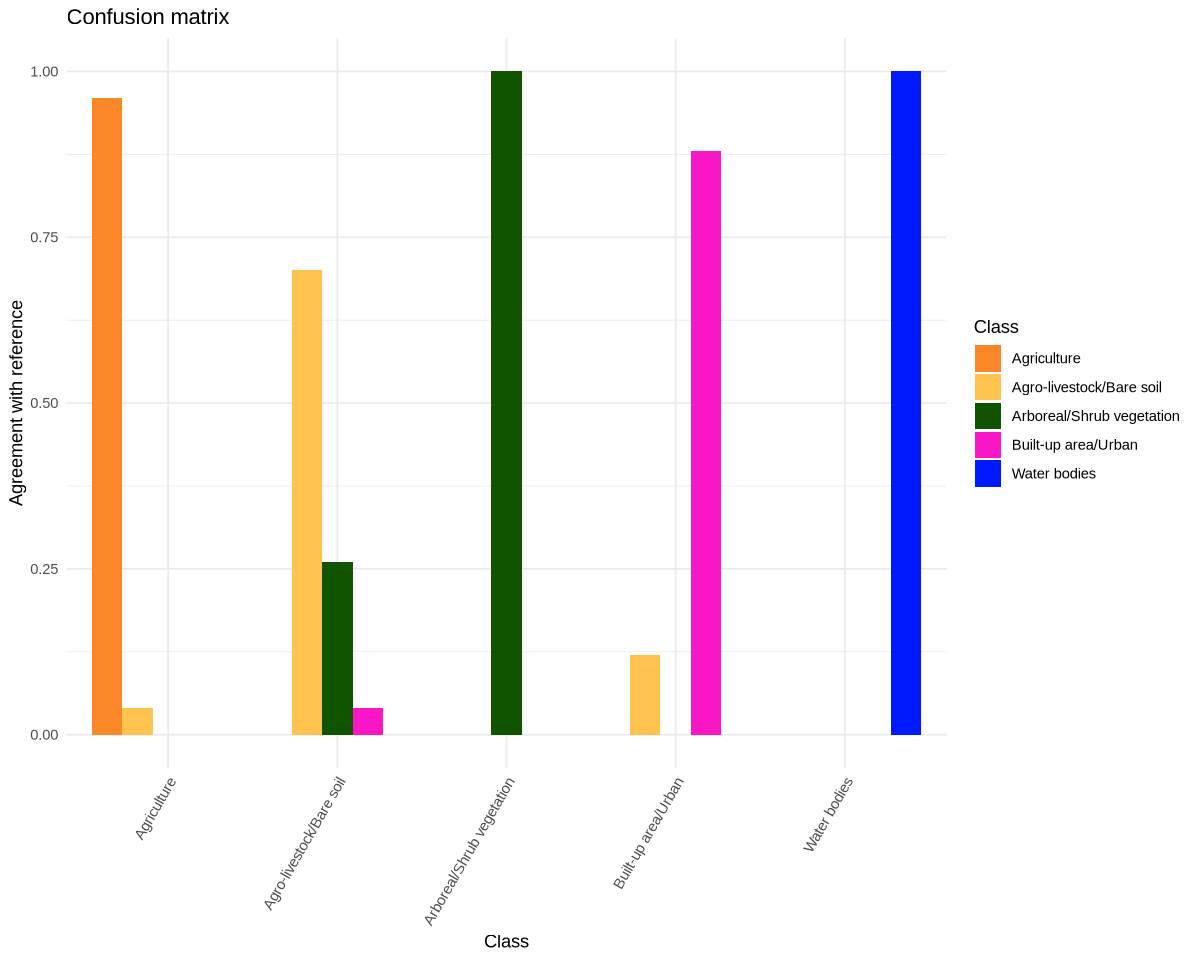

In [40]:
#
# Confusion between classes
#
options(repr.plot.width = 10, repr.plot.height = 8)
plot(acc_ltae)